In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree
from matplotlib.patches import Circle
from sklearn.model_selection import train_test_split


# basic introduction of this jupyter notebook
## 1. task comprehension
    * When a user browses properties on 99.co, after clicking into the detail page of a certain property, there will be a 'Similar listings' section on the bottom to recommend similar properties. The goal of this task is to choose and design a suitable recommendation model as there are multiple recommendation methods, and implement this model to make recommendations. Besides, we regard this recommendation problem as two subtasks, one is to collect multiple recommended properties for a certain property, and the other is to rank these recommended properties as there should be a order for webpage display.
    * Referring to reality situations and task comprehension, we have following assumptions,
        * 1)For those users who do not sign up while browsing the website, users' information is lacked, and we cannot get their basic personal info nor their browsing preference.
        * 2)For those registered users, their browsing preference may change dramatically as their demand could change with age. For example, a person may prefer condo properties with smaller size for high-quality life in their twenties and turn to hdb with larger size for raising children in their thirties.
## 2. different approaches and design decision
    * diffenrent approaches
        * There are three types of recommender systems and some naive recommendation approaches according to lectures and in the following we will discuss whether these systems or methods are suitable for this task in our consideration. After that, we will decide on which kind of method to use and how to design our model.
        * Content-based system contains recommendations based on pairwise item-item similarity and user-item similarity. Both recommendation methods are based on known user preferences but with different calculation focus. According to our basic assumption that we lack user browsing preference, this recommendation system is not considered.
        * Collaborative filtering is based on the idea that a item should be recommended to a user if other users with similar taste rated highly on this item or if this item is similar to another item which is highly rated by many other users. As for model-based CF, we import k latent representations to simulate user tastes on different items. As methods in this system are based on knowing multiple users' taste and which is contradictory to our assumption, we do not consider using this system.
        * Hybrid techniques are combined from multiple other systems or methods and in this task, we do not consider this technique. 
        * Naive recommendation approaches are easiest to understand and we can make recommendations based on item similarities without considering user preferences. So in this task, we use naive approaches.
    * design decision
        * From above discussions, we decide to use regression model, explicitly, LGBMRanker, to output final top recommendations with rank orders. As regression model need to have a training target and we cannot get rank data directly from 99.co, we have the following assumption,
            * Top 10 ranking data are accessible for each listing property on 99.co. For example, we can rank the recommended properties by user clicking times from webpage.
        and in this task, in order to fabricate ranking data, we use KD tree (which is based on KNN but could handle high dimensionality) to calculate top 10 similar properties and rank these 10 items regarding each property.
        * model design: 
            * Use KD tree to get ranking data and input this data into LGBMRanker model training as prediction target to predict top k recommendations with ranks.


## 3. model construction


### train KD tree for ranking data

#### load data

In [2]:
def load_data(df_file):
    df = pd.read_csv(df_file)
    
    return df


#### standardize data

In [3]:
def standardize_data(df, train_cols, key_col):
    standard_scalar = preprocessing.StandardScaler()
    df_standard = pd.DataFrame(standard_scalar.fit_transform(df[train_cols]), index=df[train_cols].index,columns=train_cols)
    df_standard[key_col] = df[key_col]
    
    return df_standard


#### KD tree Model training

In [4]:
def KD_model_training(df, leaf_size):
    tree = KDTree(df, leaf_size=leaf_size)
    
    return tree


#### get top 10 recommendations for each property with KD tree Model

In [5]:
# get top k recommendations for a single listing_id
def get_top_recommendations_without_rank(row_id, k, data, tree) -> pd.DataFrame:
    row = data.iloc[row_id]
    row = pd.DataFrame([row])

    dist, idx = tree.query(row, k=k+1)
    
    idx = idx[0].tolist()
    if row_id in idx:
        idx.remove(row_id)
    else: 
        idx.pop()
    df_result = data.iloc[idx]

    # Return the dataset with the k recommendations
    return df_result


In [6]:
# get top k recommendations for all listing_id in train_data
def get_top_recommendation_KD(k, data, model, key_col, train_cols):
    df_rank = pd.DataFrame()

    for i in range(data.shape[0]):
        row_recommendations = get_top_recommendations_without_rank(i, k=k, data=data, tree=model)

        row_rank = data[key_col+train_cols].iloc[row_recommendations.index.tolist()]
        row_rank['query_listing_id'] = data.iloc[i]['listing_id']

        row_rank = row_rank.reset_index().reset_index()
        row_rank['level_0'] = row_rank['level_0'].apply(lambda x: x+1)
        row_rank.rename(columns={'level_0': 'rank', 'index':'rec_index'},inplace=True)

        df_rank = pd.concat([df_rank,row_rank])
    
    df_rank = df_rank.reset_index()
    df_rank = df_rank.drop(['index'],axis=1)

    return df_rank

### Ranking model
* After constructing the above model to get top recommendations, it is reasonable to use this rank data as final recommendations with ranks. But when we look further into predicted data, we found that some predictions has same standardized feature values in each attribute and the above ranks may not be that useful. 
* So in this part, we want to try a new method called `LGBMRanker` to predict the order of these recommendations. As this method is a regression method, we need to assume a target and in this task, we set `rank` as our target.
* In the following steps, we constructed a ranking model to predict the ranking order of the recommended results, which is based on above assumption and ranking data from KB tree.

#### split train, test, evaluation data

In [7]:
def train_test_ranker_data(data, target, query, test_size, random_stante):
    # split train and test data for model training
    df_rec_train, df_rec_test = train_test_split(data, test_size=test_size, random_state=random_state)

    # split train data and evaluation data from split train data
    col_y = target

    X_train, X_val = train_test_split(df_rec_train, test_size=test_size, random_state=random_state)
    query_train = X_train.groupby(query)[query].count().to_numpy()
    query_val = X_val.groupby(query)[query].count().to_numpy()

    y_train = X_train[col_y]
    X_train = X_train[train_cols]

    y_val = X_val[col_y]
    X_val = X_val[train_cols]
    
    return X_train, y_train, X_val, y_val, query_train, query_val


#### train ranking model with train and evaluation data
* The features we use to train model are same as what we used for KB tree and reason for choosing these features is that these features are most important from task 1 feature importance analysis.
* 20% data is split from training data to make model evalution.

In [8]:
def LGBM_model_training(X_train, y_train, query_train, X_val, y_val, query_val, max_lable, eval_at, early_stopping_rounds):
    gbm = lgb.LGBMRanker(label_gain=np.arange(0, max_lable+1))
    gbm.fit(X_train, y_train, group=query_train,
            eval_set=[(X_val, y_val)], eval_group=[query_val],
            eval_at=10, early_stopping_rounds=100)

    return gbm


## 4. top recommendations

### main part in this recommendation engine to make top recommendations

In [9]:
# load data 
df_train_file = 'processed_data/processed_recommendation_train.csv'

train_cols = ['tenure', 'built_year','num_beds', 'num_baths', 'subzone_property_type_encoding', 'size_sqft', 'price']
key_col = ['listing_id']

df = load_data(df_train_file)

# standardize imported data
df_standard = standardize_data(df, train_cols, key_col)
df_standard.head()


tenure  built_year  num_beds  num_baths  subzone_property_type_encoding  \
0 -0.727365   -1.533416 -0.088056  -0.436030                       -1.148510   
1 -0.727365   -0.928910  0.685522  -0.436030                       -1.107598   
2  1.413356    0.884606  0.685522   2.288087                        0.941252   
3  1.413356    0.884606 -0.088056  -0.436030                        1.182942   
4 -0.727365    0.884606 -0.861633  -1.117060                        1.360471   

   size_sqft     price  listing_id  
0  -0.323766 -0.522277      122881  
1  -0.076257 -0.423306      259374  
2   0.728147  1.118076      665422  
3  -0.408242 -0.087724      857699  
4  -0.529844 -0.265126      216061

In [10]:
# parameters for KD tree model training
leaf_size = 5
k = 50

# train KD tree
KD_tree = KD_model_training(df_standard, leaf_size)

# # get recommended data for each property
# # getting ranking data for each property needs quite some time, so we store these data in file and read them here
# df_rank = get_top_recommendation_KD(k, data=df_standard, model=KD_tree, key_col=key_col, train_cols=train_cols)

# save df_rank to csv file and for later reading
ranking_path1 = 'processed_data/recommendation_engine_ranking_data1.csv'
ranking_path2 = 'processed_data/recommendation_engine_ranking_data2.csv'

# # save data into two csv files
# df_rank[:int(df_rank.shape[0]/2)].to_csv(ranking_path1)
# df_rank[int(df_rank.shape[0]/2):].to_csv(ranking_path2)

# read data from csv files
df_rank = pd.concat((pd.read_csv(ranking_path1), pd.read_csv(ranking_path2)))
df_rank = df_rank.drop(['Unnamed: 0'], axis=1)
df_rank = df_rank.set_index(pd.Series(range(df_rank.shape[0])))


In [18]:
# parameters for spliting train and test data and these data are used for LGBMRanker model training
target = 'rank'
query = 'query_listing_id'
test_size= 0.2
random_state = 12

# # split train and test data for model training
# df_rec_train, df_rec_test = train_test_split(df_rank, test_size=0.2, random_state=12)

# split train data and evaluation data from split train data
X_train, y_train, X_val, y_val, query_train, query_val = train_test_ranker_data(df_rank, target, query, test_size, random_state)


In [19]:
# LGBMRanker model parameters
max_lable = df_rank['rank'].nunique()
eval_at = 10
early_stopping_rounds = 100

# LGBMRanker model training
gbm_model = LGBM_model_training(X_train, y_train, query_train, X_val, y_val, query_val, max_lable, eval_at, early_stopping_rounds)


[1]	valid_0's ndcg@10: 0.830018
Training until validation scores don't improve for 100 rounds
[2]	valid_0's ndcg@10: 0.829748
[3]	valid_0's ndcg@10: 0.830438
[4]	valid_0's ndcg@10: 0.830122
[5]	valid_0's ndcg@10: 0.829727
[6]	valid_0's ndcg@10: 0.829647
[7]	valid_0's ndcg@10: 0.829972
[8]	valid_0's ndcg@10: 0.829944
[9]	valid_0's ndcg@10: 0.830001
[10]	valid_0's ndcg@10: 0.829945
[11]	valid_0's ndcg@10: 0.830185
[12]	valid_0's ndcg@10: 0.830158
[13]	valid_0's ndcg@10: 0.830406
[14]	valid_0's ndcg@10: 0.830212
[15]	valid_0's ndcg@10: 0.830185
[16]	valid_0's ndcg@10: 0.830002
[17]	valid_0's ndcg@10: 0.830001
[18]	valid_0's ndcg@10: 0.83011
[19]	valid_0's ndcg@10: 0.830034
[20]	valid_0's ndcg@10: 0.830071
[21]	valid_0's ndcg@10: 0.830008
[22]	valid_0's ndcg@10: 0.830064
[23]	valid_0's ndcg@10: 0.830055
[24]	valid_0's ndcg@10: 0.829831
[25]	valid_0's ndcg@10: 0.829872
[26]	valid_0's ndcg@10: 0.829914
[27]	valid_0's ndcg@10: 0.830002
[28]	valid_0's ndcg@10: 0.82998
[29]	valid_0's ndcg@10: 0

### make preditions for test data

In [20]:
df_rec = pd.DataFrame(df_rank)
df_rec["predicted_ranking"] = gbm_model.predict(df_rec[train_cols])
df_rec['predict_rank'] = df_rec.groupby('query_listing_id')['predicted_ranking'].rank(ascending=False)
df_rec.head(50)


rank  rec_index  listing_id    tenure  built_year  num_beds  num_baths  \
0      1        657      122873 -0.727365    0.884606 -0.088056  -0.436030   
1      2      15777      122853 -0.727365    0.884606 -0.088056   0.244999   
2      3       6779      122807 -0.727365    0.884606  0.685522   0.926028   
3      4      14158      122962  1.413356    0.884606 -0.088056   0.244999   
4      5      14988      122967 -0.727365    0.280101  0.685522   0.926028   
5      6       2384      123037 -0.727365   -2.137921 -0.861633  -1.117060   
6      7       3864      122724 -0.727365    0.280101  0.685522   1.607058   
7      8      16173      122723 -0.727365   -2.137921 -0.861633  -0.436030   
8      9      17012      123048 -0.727365    0.884606 -1.635211  -1.117060   
9     10      10595      123059 -0.727365   -0.324405 -0.088056  -0.436030   
10    11       6561      123076 -0.727365    0.884606 -0.088056  -0.436030   
11    12      10557      123083  1.413356    0.884606  0.685522  -0.436030   
12    13       4775      123084 -0.727365   -2.137921 -0.861633  -1.117060   
13    14       4393      122678 -0.727365    0.280101 -0.088056  -0.436030   
14    15        892      123186  1.413356    0.884606  0.685522   0.244999   
15    16       6979      122564 -0.727365    0.884606 -1.635211  -1.117060   
16    17      15154      122557 -0.727365    0.884606  0.685522   0.926028   
17    18      18150      123234 -0.727365    0.884606 -1.635211  -1.117060   
18    19      17549      122499 -0.727365    0.884606  0.685522   0.926028   
19    20       1526      122477  1.413356    0.884606  2.232677   2.969116   
20    21        147      122472 -0.727365   -0.928910 -0.088056  -0.436030   
21    22      11199      123300  1.413356    0.280101 -1.635211  -1.117060   
22    23        134      123368  1.413356    0.280101 -0.088056   0.244999   
23    24      19128      123434  1.413356    0.884606 -1.635211  -1.117060   
24    25      14110      122313 -0.727365    0.280101 -0.088056  -0.436030   
25    26      15084      123450 -0.727365   -2.137921 -0.861633  -0.436030   
26    27      10401      122294 -0.727365    0.884606  1.459100   0.926028   
27    28      15192      123472 -0.727365   -1.533416  0.685522   0.244999   
28    29       7935      123492  1.413356   -0.324405  1.459100   1.607058   
29    30       6567      122246  1.413356    0.280101 -0.088056   0.244999   
30    31        991      123522  1.413356    0.280101 -0.861633  -0.436030   
31    32      13032      122216 -0.727365   -1.533416 -0.088056  -0.436030   
32    33       4080      123568 -0.727365    0.884606  0.685522   0.244999   
33    34      19707      123570 -0.727365    0.280101 -0.088056  -0.436030   
34    35       9721      123594  1.413356   -0.324405  1.459100   2.969116   
35    36       3585      123595 -0.727365    0.884606 -0.861633  -0.436030   
36    37      16754      122167  1.413356   -2.137921  2.232677   2.969116   
37    38      16117      123601 -0.727365    0.280101 -1.635211  -1.117060   
38    39      19338      123608  1.413356    0.884606 -0.088056  -0.436030   
39    40      18529      122138  0.342996   -2.137921  1.459100   2.288087   
40    41       3549      123670 -0.727365   -2.137921 -0.088056  -0.436030   
41    42       9677      123671 -0.727365   -2.137921 -0.861633  -0.436030   
42    43      10343      123678 -0.727365    0.884606 -0.088056  -0.436030   
43    44      13950      123684  1.413356   -0.324405  3.006255   2.288087   
44    45       4738      122021 -0.727365    0.280101 -0.861633  -0.436030   
45    46       4285      123745  1.413356    0.280101  2.232677   2.288087   
46    47      14615      121989 -0.727365   -0.928910 -0.088056  -0.436030   
47    48      20067      121928  1.413356    0.884606 -0.861633  -1.117060   
48    49      14013      123840  1.413356    0.884606 -0.861633  -1.117060   
49    50      15875      121907 -0.727365    0.884606  0.685522  -0.436030   

    subzone_property_type

### return top 5 recommendations for test data
* As we split all data into train data and test data, if we just return our top k recommendations in test data, there might no result return. So we put fabricated ranking data and predicting data together for task return

In [14]:
def get_top_recommendations(data, query_listing_id, k) -> pd.DataFrame:
    
    #####################################################
    ## Initialize the required parameters
    
    # The number of recommendations seem recommended
    # Additional input parameters are up to you
    k = k
    
    # Extract all **kwargs input parameters
    # and set the used paramaters (here: k)

       
    #####################################################
    ## Compute your recommendations
    #
    # This is where your magic happens. Of course, you can call methods
    # defined in this notebook or in external Python (.py) scripts
    #
        
    # Here, we just return the input row k times
    # Ideally, you recommendations will be much better
    df_result = data[data['query_listing_id']==query_listing_id]
    df_result = df_result.sort_values(by="predict_rank", ascending=True)

    # Return the dataset with the k recommendations
    return df_result.iloc[:k]


In [29]:
pd.set_option('display.max_columns', None)

In [30]:
# Pick a row id of choice
# row_id = 10
# row_id = 20
row_id = 30
# row_id = 40
# row_id = 50

origin_data_file = 'data/train.csv'
origin_data = load_data('data/train.csv')

# Get the row from the dataframe (an invalid row ids will throw an error)
row = origin_data.iloc[row_id]

# Just for printing it nicely, we create a new dataframe from this single row
pd.DataFrame([row])

listing_id                         title            address property_name  \
30      645643  3 bed condo for sale in 1953  1 tessensohn road          1953   

   property_type    tenure  built_year  num_beds  num_baths  size_sqft  \
30     Apartment  freehold      2023.0       3.0        3.0       1130   

    floor_level   furnishing         available_unit_types  total_num_units  \
30          NaN  unspecified  studio, 1, 2, 3, 4, 5, 6 br             58.0   

                                 property_details_url        lat         lng  \
30  https://www.99.co/singapore/condos-apartments/...  14.484814  121.023232   

    elevation  subzone  planning_area      price  
30          0      NaN            NaN  2671200.0

In [31]:
k = 3

df_recommendations = get_top_recommendations(df_rec, row['listing_id'], k=k)

origin_data[origin_data['listing_id'].isin(df_recommendations.listing_id.to_list())]



listing_id                                         title  \
50        644995  5 bed house for sale in seletar hills estate   
776       646145       4 bed house for sale in hillview villas   
8419      646552     5 bed house for sale in kismis residences   

                address         property_name        property_type    tenure  \
50         jalan bangau  seletar hills estate  semi-detached house  freehold   
776   hillview crescent       hillview villas       Terraced House  freehold   
8419      lorong kismis     kismis residences  Semi-Detached House  freehold   

      built_year  num_beds  num_baths  size_sqft floor_level   furnishing  \
50        2013.0       5.0        6.0       5000         NaN  unspecified   
776       1993.0       4.0        4.0       3014         NaN  unspecified   
8419      2018.0       5.0        5.0       7700         NaN  unspecified   

     available_unit_types  total_num_units  \
50    3, 4, 5, 6, 7, 8 br              NaN   
776               4, 5 br            138.0   
8419           4, 5, 6 br             31.0   

                                   property_details_url       lat         lng  \
50    https://www.99.co/singapore/houses/seletar-hil...  1.387049  103.872999   
776   https://www.99.co/singapore/houses/hillview-vi...  1.356750  103.751897   
8419  https://www.99.co/singapore/houses/kismis-resi...  1.338660  103.771662   

      elevation        subzone planning_area      price  
50            0  seletar hills     serangoon  7119000.0  
776           0         guilin   bukit batok  4179000.0  
8419          0     anak bukit   bukit timah  9135000.0

### feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

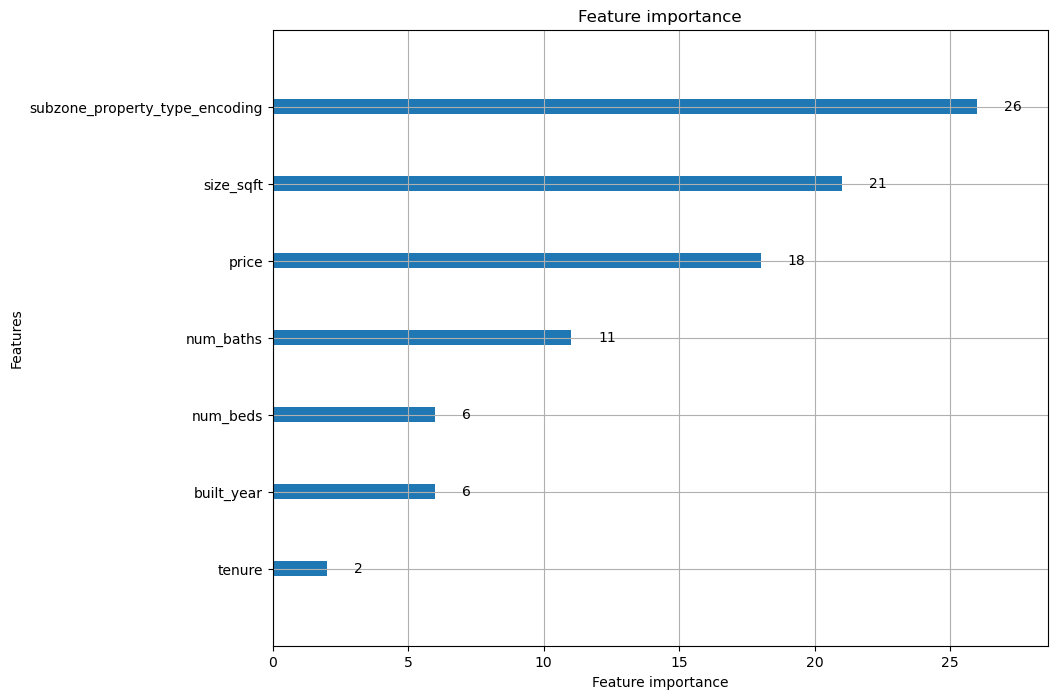

In [32]:
lgb.plot_importance(gbm_model, figsize = (10,8))